In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

tf.random.set_seed(1)


In [2]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    comp1 = inputs[1][idx]
    comp2 = inputs[2][idx]
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    fig, ax = plt.subplots(6, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(comp1[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(comp2[i], ax[2, i], f'comp2 {idx[i]}')
        showimg(output_img1[i], ax[3, i], f'output1\n{encoding}')
        showimg(output_img2[i], ax[4, i], f'output2\n{encoding}')
        showimg(output_img1[i] + output_img2[i], ax[5, i], f'outblend\n{encoding}')
    return idx

In [3]:
(train_img, train_class),(test_img, test_class)=tf.keras.datasets.mnist.load_data()

# MAKING THINGS A BIT EASIER BY NARROWING DOWN TO TWO CLASSES
train_img = train_img[(train_class == 8) | (train_class == 7)]
test_img = test_img[(test_class == 8) | (test_class == 7)]

resized_height = 32
resized_width = 32
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(resized_height, resized_width),
  layers.Rescaling(1./255)
])

height,width=28,28
train_img=train_img.reshape(train_img.shape[0],height,width,1).astype('float32')
train_img= resize_and_rescale(train_img)
#train_img/=255

test_img=test_img.reshape(test_img.shape[0],height,width,1).astype('float32')
test_img= resize_and_rescale(test_img)
#test_img/=255

In [4]:
batch_size = 100

In [5]:
# PREVIOUS LATENT DIMENSIONS WAS ONLY 2!
# WAY TOO SMALL TO ENCODE INFO HENCE POOR RESULTS
latent_dimensions = 32

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=30, width_shift_range=0.3, height_shift_range=0.3,
                           shear_range=0.0, zoom_range=[1.5, 2.5], )

# PREVIOUSLY WAS NOT USING A LOT OF THE DATA
gen=datagen.flow(train_img, None, batch_size=1)

num=60000
comps=2
components=np.array([[gen.next()[0, ..., 0] for j in range(num)] for i in range(comps)])
blended=components.sum(axis=0)
blended=blended.reshape(blended.shape[0],resized_height, resized_width,1).astype('float32')
print(blended.shape)
components = components.reshape(2, blended.shape[0], resized_height, resized_width,1).astype('float32')
print(components.shape)
# WOULD BE BEST TO SAVE THIS TO DISK AND JUST READ IN RATHER THAN GENERATING EVERY TIME

(60000, 32, 32, 1)
(2, 60000, 32, 32, 1)


In [7]:
blended.shape, components.shape

((60000, 32, 32, 1), (2, 60000, 32, 32, 1))

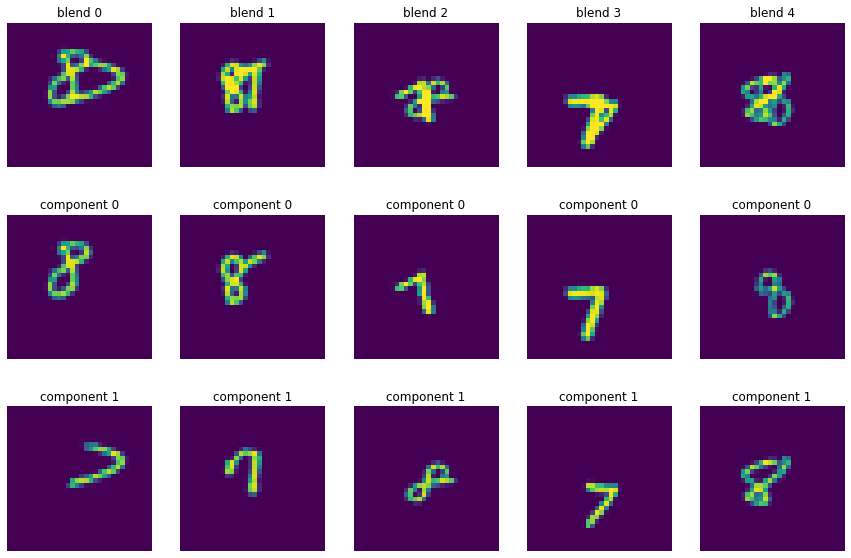

In [8]:
n = 5
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[i],ax[0,i],f'blend {i}')
    for j in range(comps):
        showimg(components[j,i],ax[j+1,i],f'component {j}')  

In [9]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    return x

In [10]:
def decoder(x):
    #x=UpSampling2D()(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [11]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [12]:
# encoder
input_blend=Input(shape=(resized_height, resized_width,1))

encoded=encoder(input_blend)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

In [13]:
# decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

embed2=Dense(np.prod(shape),activation='relu')(input_embed)
embed2=Reshape(shape)(embed2)
decoded2=decoder(embed2)
output2=Conv2DTranspose(1,3,padding='same')(decoded2)

In [14]:
encode=Model(input_blend,z)
encode.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 32)     9248        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 64)     18496       ['conv2d_1[0][0]']               
                                                                                              

In [15]:
input_component1 = Input(shape=(resized_height, resized_width, 1))
input_component2 = Input(shape=(resized_height, resized_width, 1))

decode=Model([input_embed, input_component1, input_component2], [output1, output2])
decode.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 256)          8448        ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 256)          8448        ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 2, 2, 64)     0           ['dense_2[0][0]']                
                                                                                            

In [16]:
encoding = encode(input_blend)
re1, re2 = decode([encoding, input_component1, input_component2])

vae = Model([input_blend, input_component1, input_component2], [re1, re2])

In [17]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 32)           81440       ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                            

In [18]:
# I FORGOT ABOUT THIS: WE NEED TO CONSIDER THAT THE COMPONENTS COULD BE EITHER WAY ROUND
mse_lossA = mse(input_component1, re1) + mse(input_component2, re2)
mse_lossA = tf.reduce_mean(mse_lossA / 2, axis=(1, 2))
mse_lossB = mse(input_component1, re2) + mse(input_component2, re1)
mse_lossB = tf.reduce_mean(mse_lossB / 2, axis=(1, 2))
mse_loss = tf.reduce_mean(tf.minimum(mse_lossA, mse_lossB)) * height * width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss, 'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*0.1
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

print(blended.shape)
print(components[0].shape)
print(components[1].shape)
together = [blended, components[0], components[1]]

vae.compile(optimizer=Adam())

(60000, 32, 32, 1)
(60000, 32, 32, 1)
(60000, 32, 32, 1)


In [19]:
#print(together)
history=vae.fit(together, verbose=1, epochs=3, batch_size=batch_size)

Epoch 1/3
453/600 [=====================>........] - ETA: 21s - loss: 10.9995 - mse_loss: 10.8159 - kl_loss: 0.1837

KeyboardInterrupt: 

In [ ]:
n=5
chosen=summary_plot(n,together,decode)